In [6]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from scipy.stats import ttest_ind, f_oneway
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import joblib

In [8]:
df = pd.read_csv('insurance.csv')
print('Shape:', df.shape)
print(df.head())
print(df.dtypes)
print(df.isnull().sum())
print(df.describe())

Shape: (1338, 7)
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.0

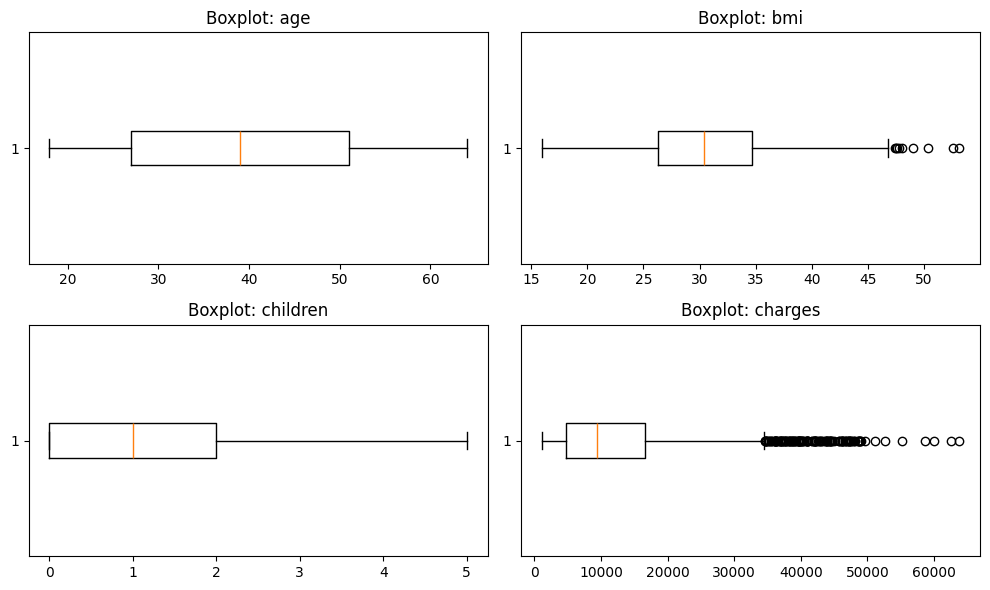

Outliers (IQR rule):
age           0
bmi           9
children      0
charges     139
dtype: int64


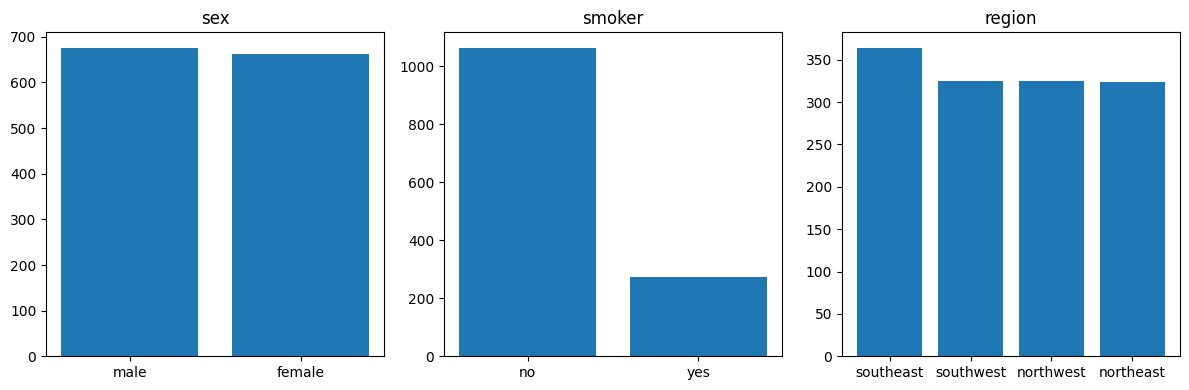

In [ ]:
numeric_cols = ['age','bmi','children','charges']
plt.figure(figsize=(10,6))
for i,col in enumerate(numeric_cols,1):
    plt.subplot(2,2,i)
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f'Boxplot: {col}')
plt.tight_layout()
plt.show()

Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outliers = ((df[numeric_cols] < lower) | (df[numeric_cols] > upper)).sum()
print('Outliers (IQR rule):')
print(outliers)

cat_cols = ['sex','smoker','region']
plt.figure(figsize=(12,4))
for i,col in enumerate(cat_cols,1):
    plt.subplot(1,3,i)
    counts = df[col].value_counts()
    plt.bar(counts.index, counts.values)
    plt.title(col)
plt.tight_layout()
plt.show()

Я предпринимаю решение сохранить эти выбросы так как они имеют ценность как данные отражающие хоть и редкие но реальные показатели

In [10]:
df['charges_log'] = np.log1p(df['charges'])

X = df.drop(columns=['charges','charges_log'])
X = pd.get_dummies(X, drop_first=True)
y = df['charges']

preproc_path = 'insurance_preprocessed.csv'
pd.concat([X, y.reset_index(drop=True)], axis=1).to_csv(preproc_path, index=False)
print('Saved preprocessed to', preproc_path)
X.head()

Saved preprocessed to insurance_preprocessed.csv


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,False,True,False,False,True
1,18,33.770,1,True,False,False,True,False
2,28,33.000,3,True,False,False,True,False
3,33,22.705,0,True,False,True,False,False
4,32,28.880,0,True,False,True,False,False


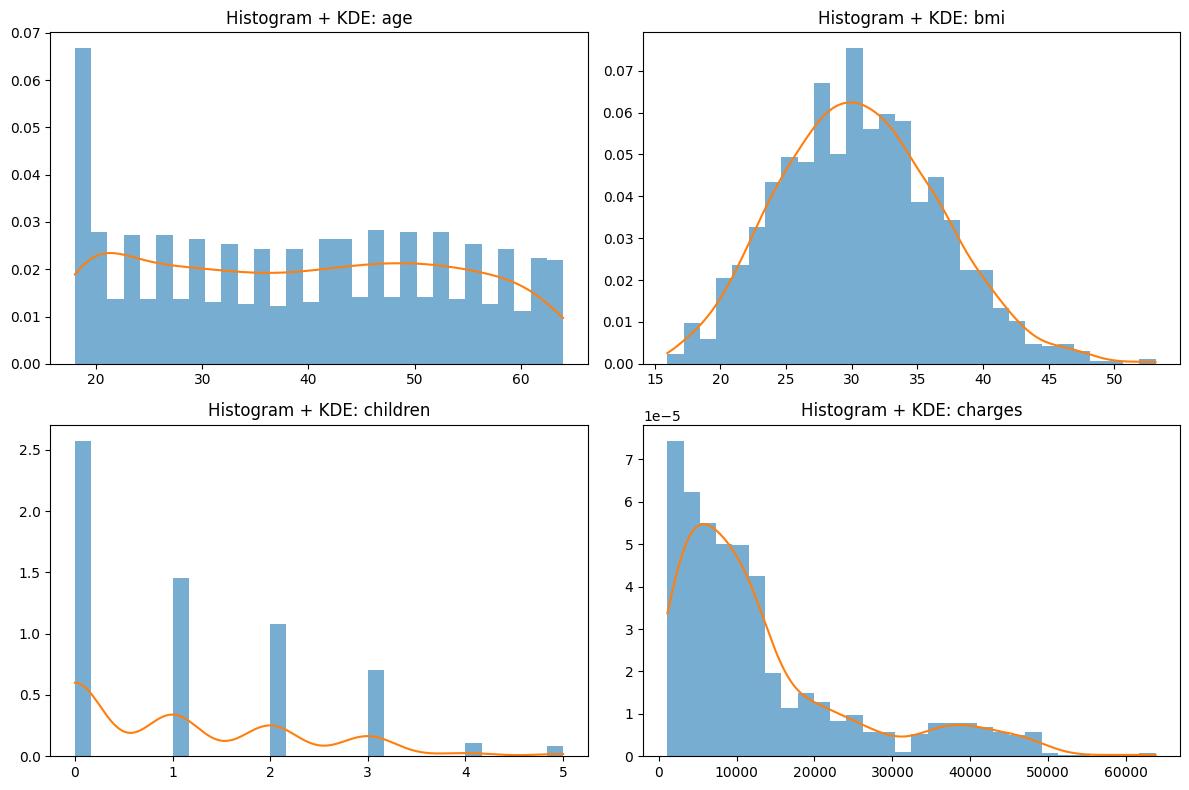

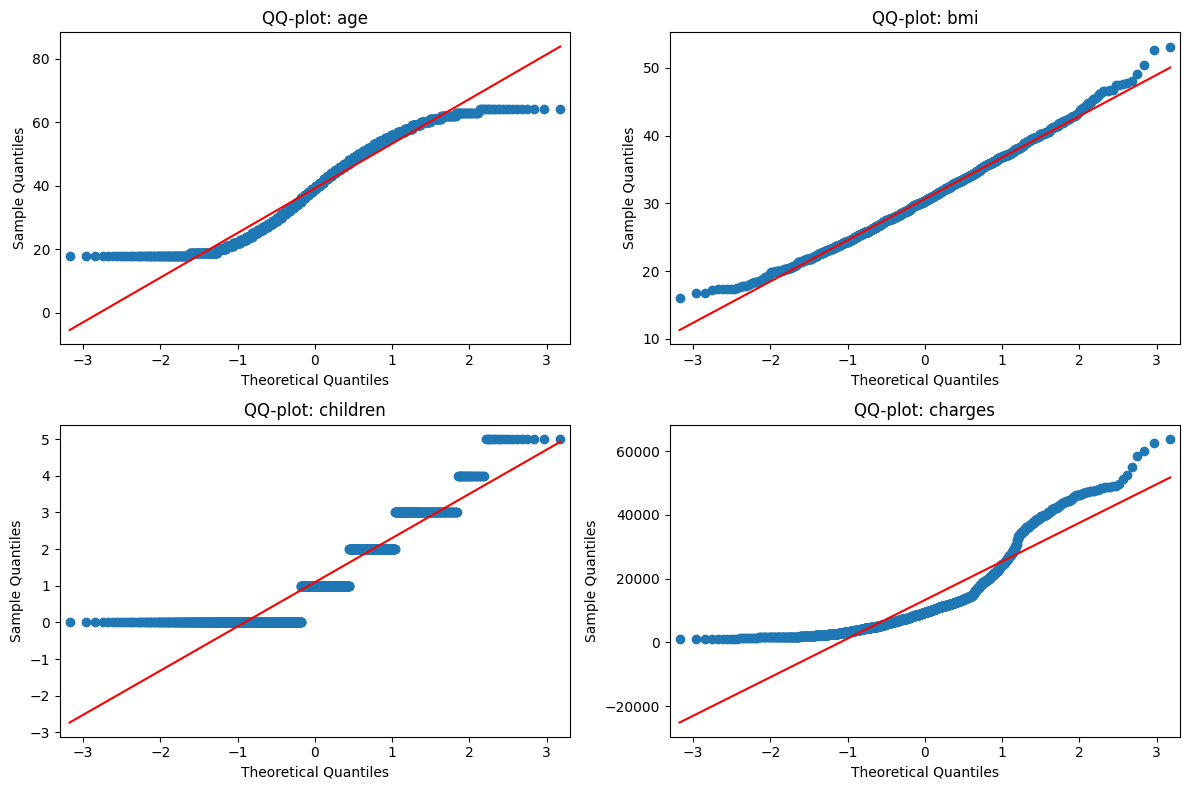

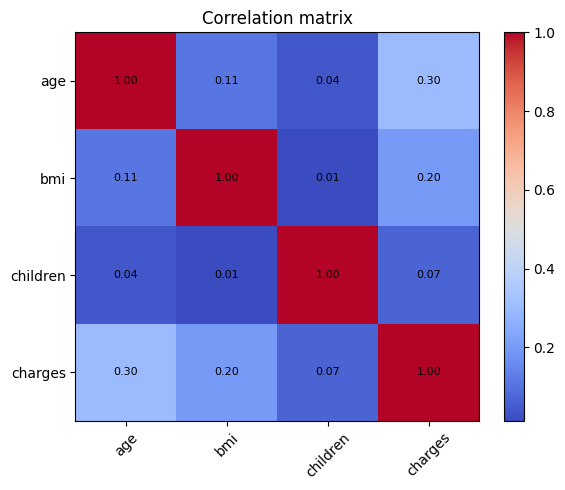

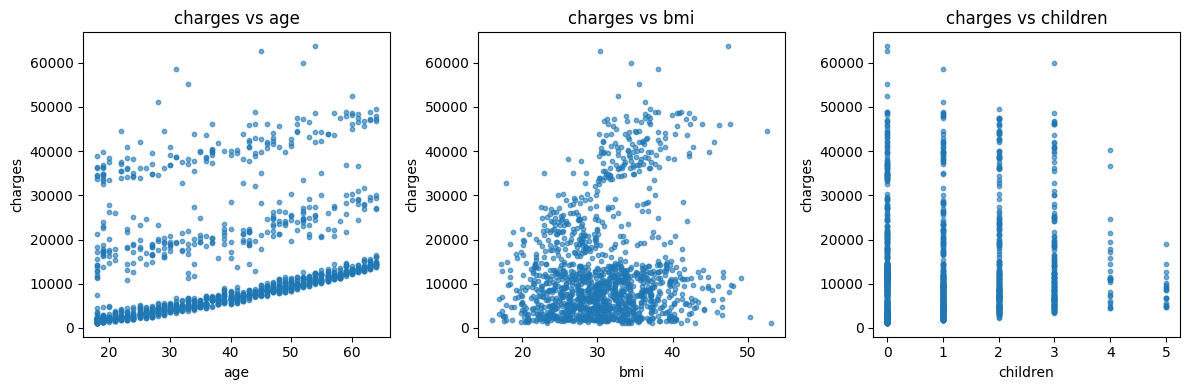

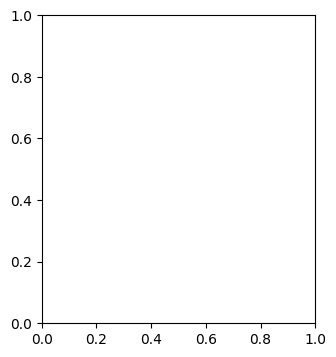

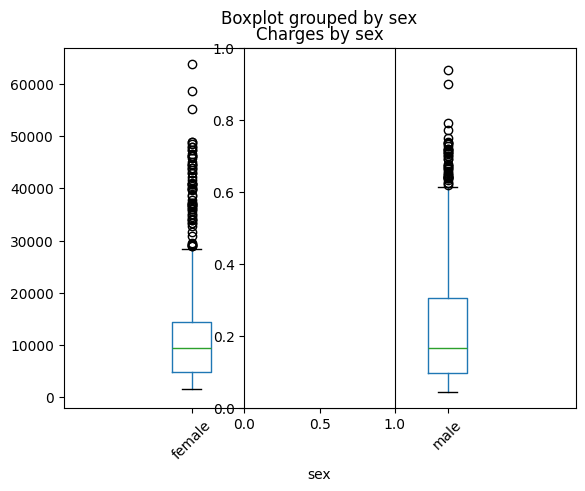

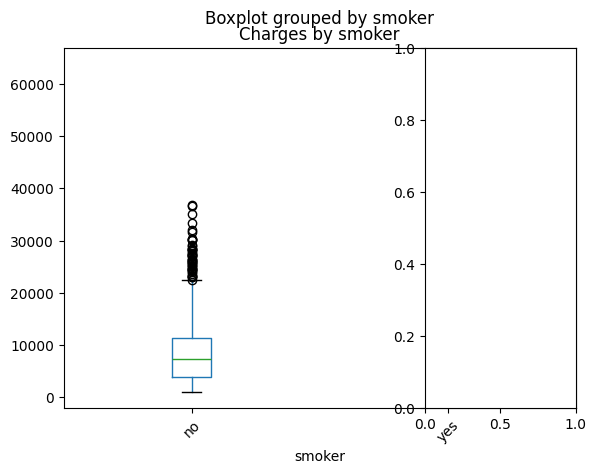

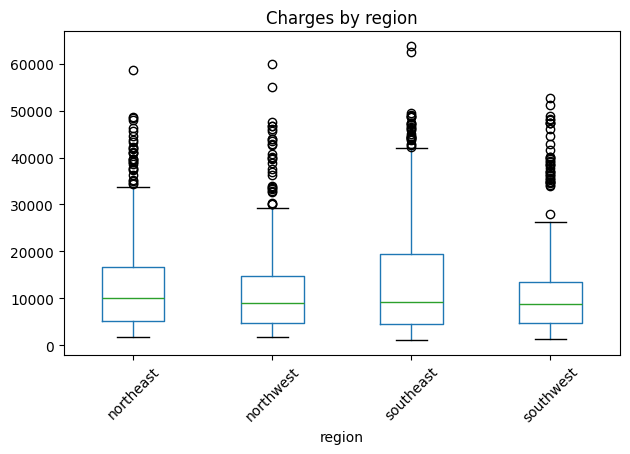

In [11]:

numeric_plot_cols = ['age','bmi','children','charges']
plt.figure(figsize=(12,8))
for i,col in enumerate(numeric_plot_cols,1):
    plt.subplot(2,2,i)
    vals = df[col].dropna()
    plt.hist(vals, bins=30, density=True, alpha=0.6)
    try:
        kde = stats.gaussian_kde(vals)
        xs = np.linspace(vals.min(), vals.max(), 200)
        plt.plot(xs, kde(xs))
    except Exception:
        pass
    plt.title(f'Histogram + KDE: {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,8))
for i,col in enumerate(numeric_plot_cols,1):
    plt.subplot(2,2,i)
    sm.qqplot(df[col].dropna(), line='s', ax=plt.gca())
    plt.title(f'QQ-plot: {col}')
plt.tight_layout()
plt.show()

corr = df[numeric_plot_cols].corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap='coolwarm', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=45)
plt.yticks(range(len(corr)), corr.index)
for i in range(len(corr)):
    for j in range(len(corr)):
        plt.text(j,i,f"{corr.iloc[i,j]:.2f}",ha='center',va='center',fontsize=8)
plt.title('Correlation matrix')
plt.tight_layout()
plt.show()

# Scatter plots
pairs = [('age','charges'),('bmi','charges'),('children','charges')]
plt.figure(figsize=(12,4))
for i,(x,ycol) in enumerate(pairs,1):
    plt.subplot(1,3,i)
    plt.scatter(df[x], df[ycol], s=10, alpha=0.6)
    plt.xlabel(x); plt.ylabel(ycol)
    plt.title(f'{ycol} vs {x}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
for i,col in enumerate(['sex','smoker','region'],1):
    plt.subplot(1,3,i)
    df.boxplot(column='charges', by=col, grid=False, rot=45)
    plt.title(f'Charges by {col}')
plt.suptitle('')
plt.tight_layout()
plt.show()

In [12]:
print(df[['age','bmi','children','charges']].describe())
print('\nSkewness:')
print(df[['age','bmi','children','charges']].skew())
print('\nKurtosis:')
print(df[['age','bmi','children','charges']].kurtosis())

for col in ['age','bmi','children','charges']:
    sample = df[col].dropna()
    if sample.shape[0] > 500:
        sample = sample.sample(500, random_state=42)
    stat,p = stats.shapiro(sample)
    print(f'Shapiro {col}: W={stat:.4f}, p={p:.4g}')

s = df[df['smoker']=='yes']['charges']
sn = df[df['smoker']=='no']['charges']
stat,p = ttest_ind(s,sn, equal_var=False)
print('\nT-test smoker vs non-smoker: t={:.4f}, p={:.4g}'.format(stat,p))

groups = [df[df['region']==r]['charges'] for r in df['region'].unique()]
F,p = f_oneway(*groups)
print('ANOVA region: F={:.4f}, p={:.4g}'.format(F,p))

from statsmodels.stats.outliers_influence import variance_inflation_factor
X_vif = df[['age','bmi','children']]
X_vif = sm.add_constant(X_vif)
vif = pd.DataFrame({'feature': X_vif.columns, 'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]})
print('\nVIF:\n', vif)

               age          bmi     children       charges
count  1338.000000  1338.000000  1338.000000   1338.000000
mean     39.207025    30.663397     1.094918  13270.422265
std      14.049960     6.098187     1.205493  12110.011237
min      18.000000    15.960000     0.000000   1121.873900
25%      27.000000    26.296250     0.000000   4740.287150
50%      39.000000    30.400000     1.000000   9382.033000
75%      51.000000    34.693750     2.000000  16639.912515
max      64.000000    53.130000     5.000000  63770.428010

Skewness:
age         0.055673
bmi         0.284047
children    0.938380
charges     1.515880
dtype: float64

Kurtosis:
age        -1.245088
bmi        -0.050732
children    0.202454
charges     1.606299
dtype: float64
Shapiro age: W=0.9487, p=3.837e-12
Shapiro bmi: W=0.9929, p=0.01864
Shapiro children: W=0.8203, p=3.112e-23
Shapiro charges: W=0.8091, p=7.228e-24

T-test smoker vs non-smoker: t=32.7519, p=5.889e-103
ANOVA region: F=2.9696, p=0.03089

VIF:
     fea

In [13]:
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[['age','bmi','children']] = scaler.fit_transform(X[['age','bmi','children']])
joblib.dump(scaler, 'standard_scaler.joblib')
print('Scaler saved to standard_scaler.joblib')
X_scaled.head()

Scaler saved to standard_scaler.joblib


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,-0.908614,False,True,False,False,True
1,-1.509965,0.509621,-0.078767,True,False,False,True,False
2,-0.797954,0.383307,1.580926,True,False,False,True,False
3,-0.441948,-1.305531,-0.908614,True,False,True,False,False
4,-0.513149,-0.292556,-0.908614,True,False,True,False,False


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print('Train/test sizes:', X_train.shape, X_test.shape)

lr = LinearRegression()
lr.fit(X_train, y_train)
coeffs = pd.Series(lr.coef_, index=X_scaled.columns).sort_values(key=abs, ascending=False)
print('\nTop coefficients:')
print(coeffs.head(15))

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(lr, X_scaled, y, cv=kf, scoring='r2')
cv_mse = -cross_val_score(lr, X_scaled, y, cv=kf, scoring='neg_mean_squared_error')
print('\nCV R2:', cv_r2)
print('Mean CV R2:', cv_r2.mean())
print('Mean CV MSE:', cv_mse.mean())
joblib.dump(lr, 'linear_model.joblib')
print('Linear model saved to linear_model.joblib')

Train/test sizes: (1070, 8) (268, 8)

Top coefficients:
smoker_yes          23651.128856
age                  3609.149018
bmi                  2054.885063
region_southwest     -809.799354
region_southeast     -657.864297
children              512.478869
region_northwest     -370.677326
sex_male              -18.591692
dtype: float64

CV R2: [0.78359298 0.7380458  0.79558615 0.63243806 0.75131533]
Mean CV R2: 0.7401956629640443
Mean CV MSE: 36998683.915473595
Linear model saved to linear_model.joblib


R2=0.7836, MSE=33596915.85, RMSE=5796.28, MAE=4181.19


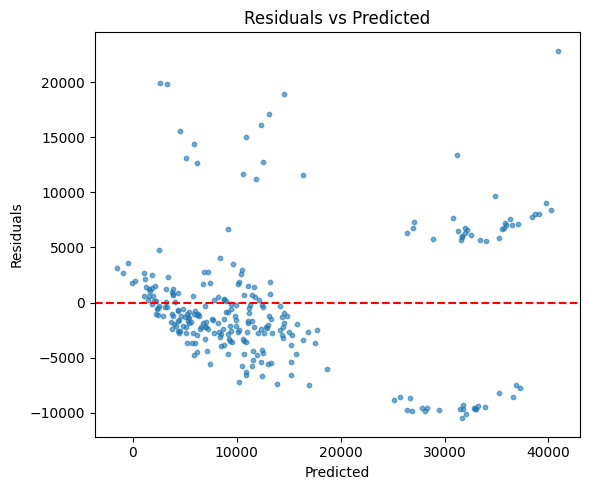

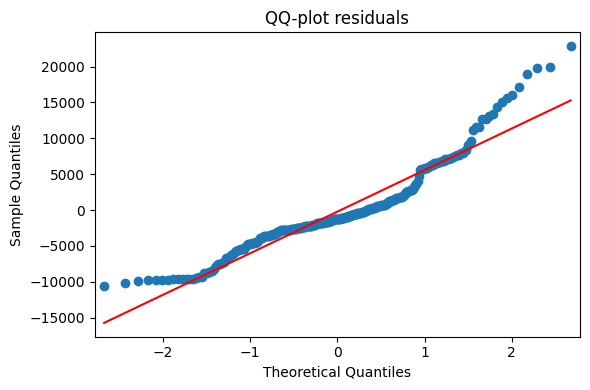

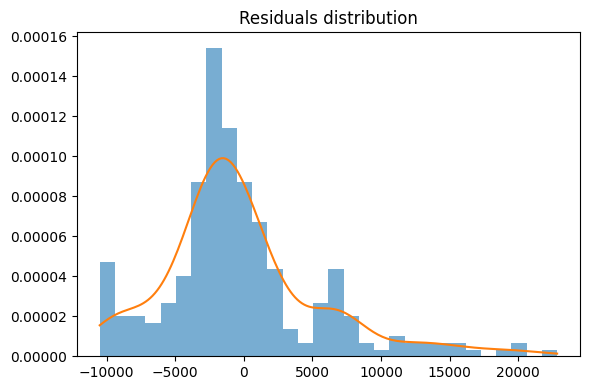

In [15]:
y_pred = lr.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print(f'R2={r2:.4f}, MSE={mse:.2f}, RMSE={rmse:.2f}, MAE={mae:.2f}')

residuals = y_test - y_pred

plt.figure(figsize=(6,5))
plt.scatter(y_pred, residuals, s=10, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title('QQ-plot residuals')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30, density=True, alpha=0.6)
try:
    kde = stats.gaussian_kde(residuals)
    xs = np.linspace(residuals.min(), residuals.max(), 200)
    plt.plot(xs, kde(xs))
except Exception:
    pass
plt.title('Residuals distribution')
plt.tight_layout()
plt.show()

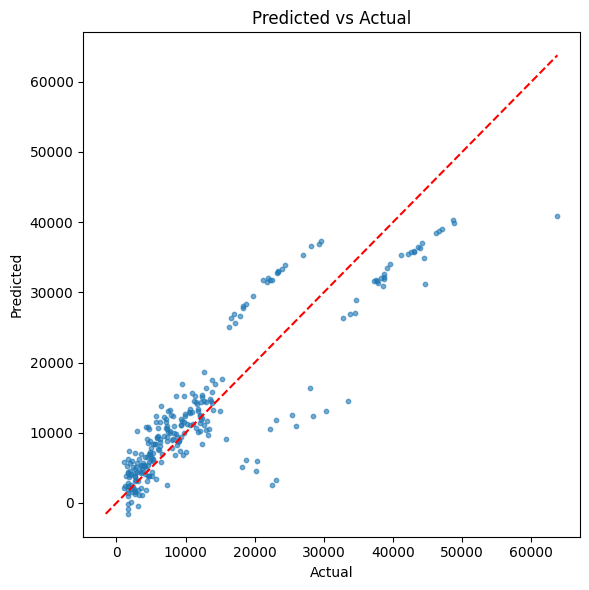

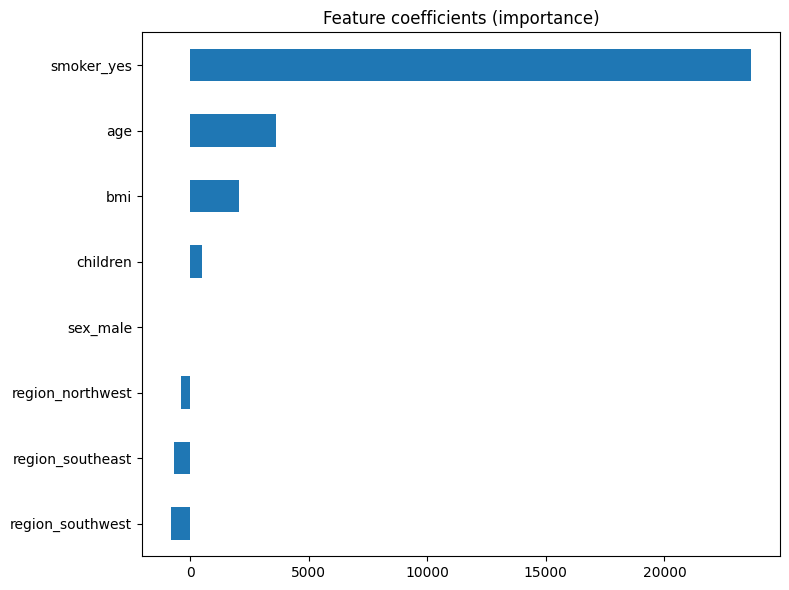

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, s=10, alpha=0.6)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
plt.plot(lims, lims, 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.tight_layout()
plt.show()

coeff_series = pd.Series(lr.coef_, index=X_scaled.columns).sort_values()
plt.figure(figsize=(8,6))
coeff_series.plot(kind='barh')
plt.title('Feature coefficients (importance)')
plt.tight_layout()
plt.show()